In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
# Time series modeling libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv("E:/VaccineLedger/Backend/data/vaccine_demand_forecasting.csv")

In [4]:
df.head()

,Date,District,Vaccine Type,Administered Doses,Temperature,Rainfall,Stock Left,Holiday Indicator
0,2024-01-01,Pune,BCG,120,22.5,0.0,300,0
1,2024-01-01,Mumbai,Polio,200,24.0,0.0,500,0
2,2024-01-01,Nashik,Measles,80,20.0,2.5,150,0
3,2024-01-02,Pune,BCG,130,22.0,0.0,280,0
4,2024-01-02,Mumbai,Polio,210,24.5,0.0,480,0


In [5]:
df['District'].unique()

array(['Pune', 'Mumbai', 'Nashik'], dtype=object)

In [6]:
df['Vaccine Type'].unique()

array(['BCG', 'Polio', 'Measles'], dtype=object)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df['Date']

0     2024-01-01
1     2024-01-01
2     2024-01-01
3     2024-01-02
4     2024-01-02
         ...    
133   2024-02-13
134   2024-02-13
135   2024-02-14
136   2024-02-14
137   2024-02-14
Name: Date, Length: 138, dtype: datetime64[ns]

In [16]:
df = df.sort_values('Date').reset_index(drop=True)

In [17]:
df.head()

,Date,District,Vaccine Type,Administered Doses,Temperature,Rainfall,Stock Left,Holiday Indicator
0,2024-01-01,Pune,BCG,120,22.5,0.0,300,0
1,2024-01-01,Mumbai,Polio,200,24.0,0.0,500,0
2,2024-01-01,Nashik,Measles,80,20.0,2.5,150,0
3,2024-01-02,Pune,BCG,130,22.0,0.0,280,0
4,2024-01-02,Mumbai,Polio,210,24.5,0.0,480,0


In [18]:
print(f"Date range varries from {df['Date'].min()} to {df['Date'].max()}")

Date range varries from 2024-01-01 00:00:00 to 2024-02-14 00:00:00


In [19]:
# ==================== EXPLORATORY DATA ANALYSIS ====================
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Basic statistics
print("\n1. Basic Statistics:")
print(df.describe())

# Check for missing values
print(f"\n2. Missing Values:")
print(df.isnull().sum())

# Data types
print(f"\n3. Data Types:")
print(df.dtypes)



=== EXPLORATORY DATA ANALYSIS ===

1. Basic Statistics:
                                Date  Administered Doses  Temperature  \
count                            138          138.000000   138.000000   
mean   2024-01-23 04:10:26.086956544          243.115942    31.737681   
min              2024-01-01 00:00:00           80.000000    19.500000   
25%              2024-01-12 00:00:00          185.000000    27.000000   
50%              2024-01-23 12:00:00          242.500000    32.750000   
75%              2024-02-03 00:00:00          298.750000    36.375000   
max              2024-02-14 00:00:00          415.000000    41.200000   
std                              NaN           80.770023     5.703849   

         Rainfall  Stock Left  Holiday Indicator  
count  138.000000  138.000000         138.000000  
mean     0.037681  116.666667           0.130435  
min      0.000000    0.000000           0.000000  
25%      0.000000    0.000000           0.000000  
50%      0.000000   55.000000 

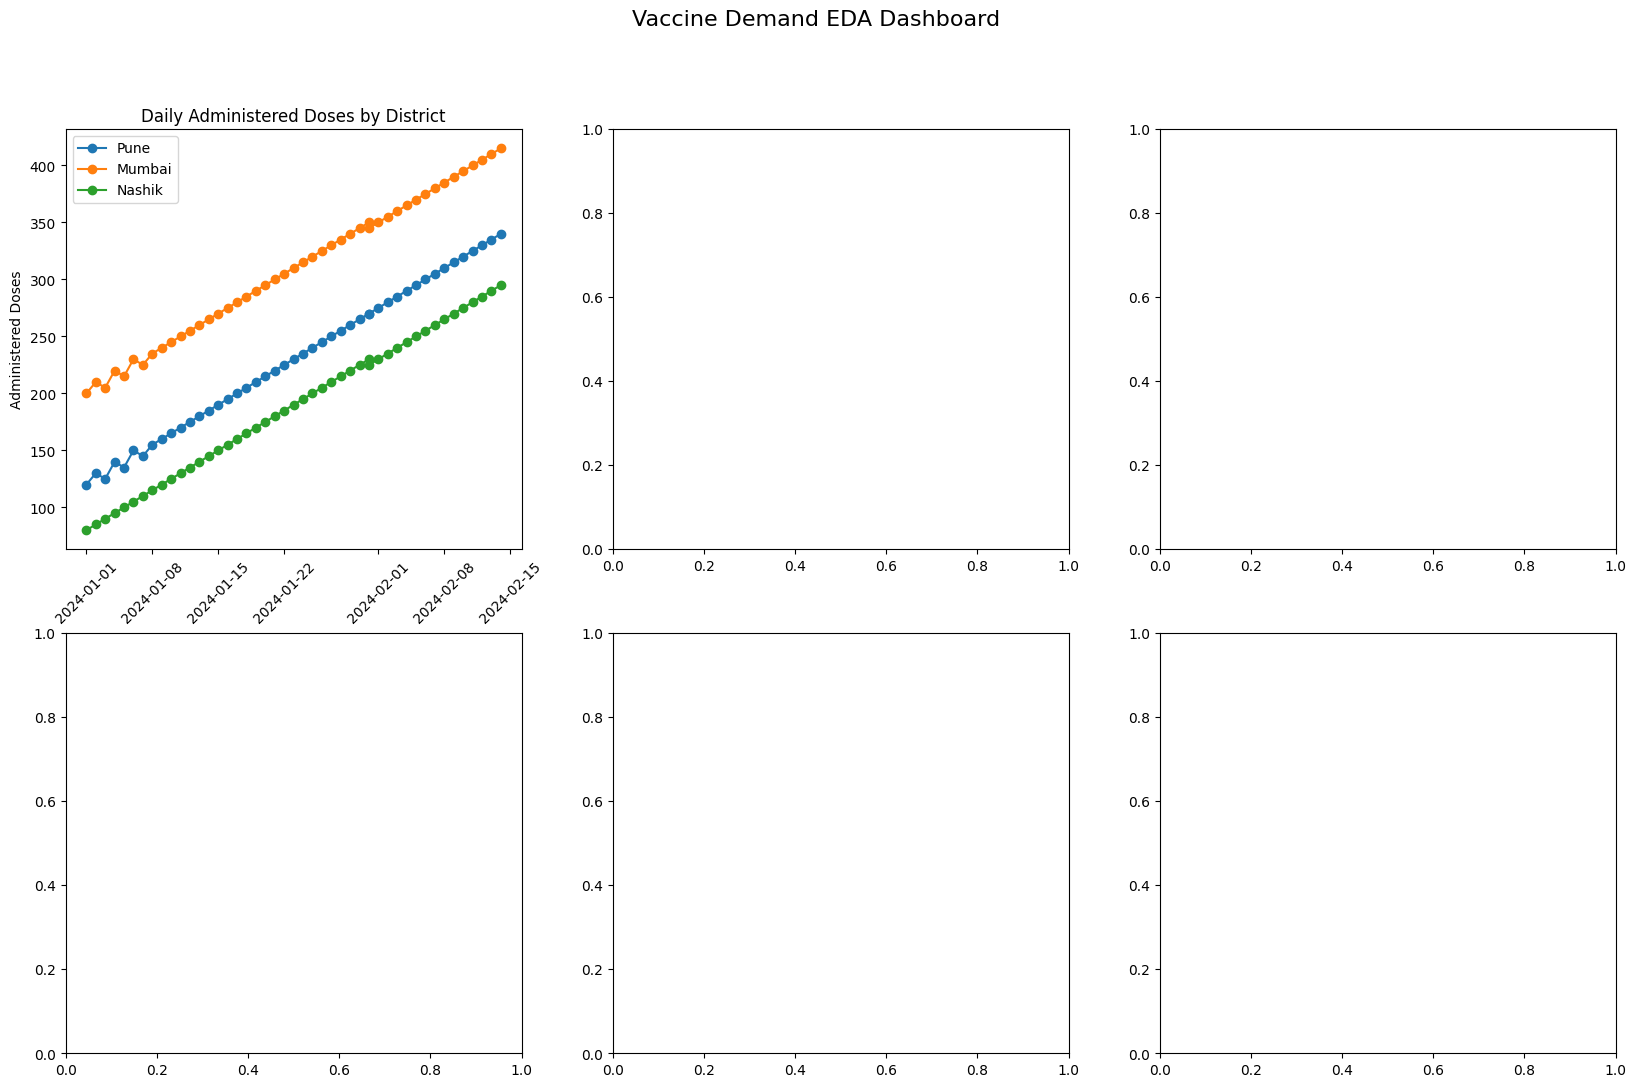

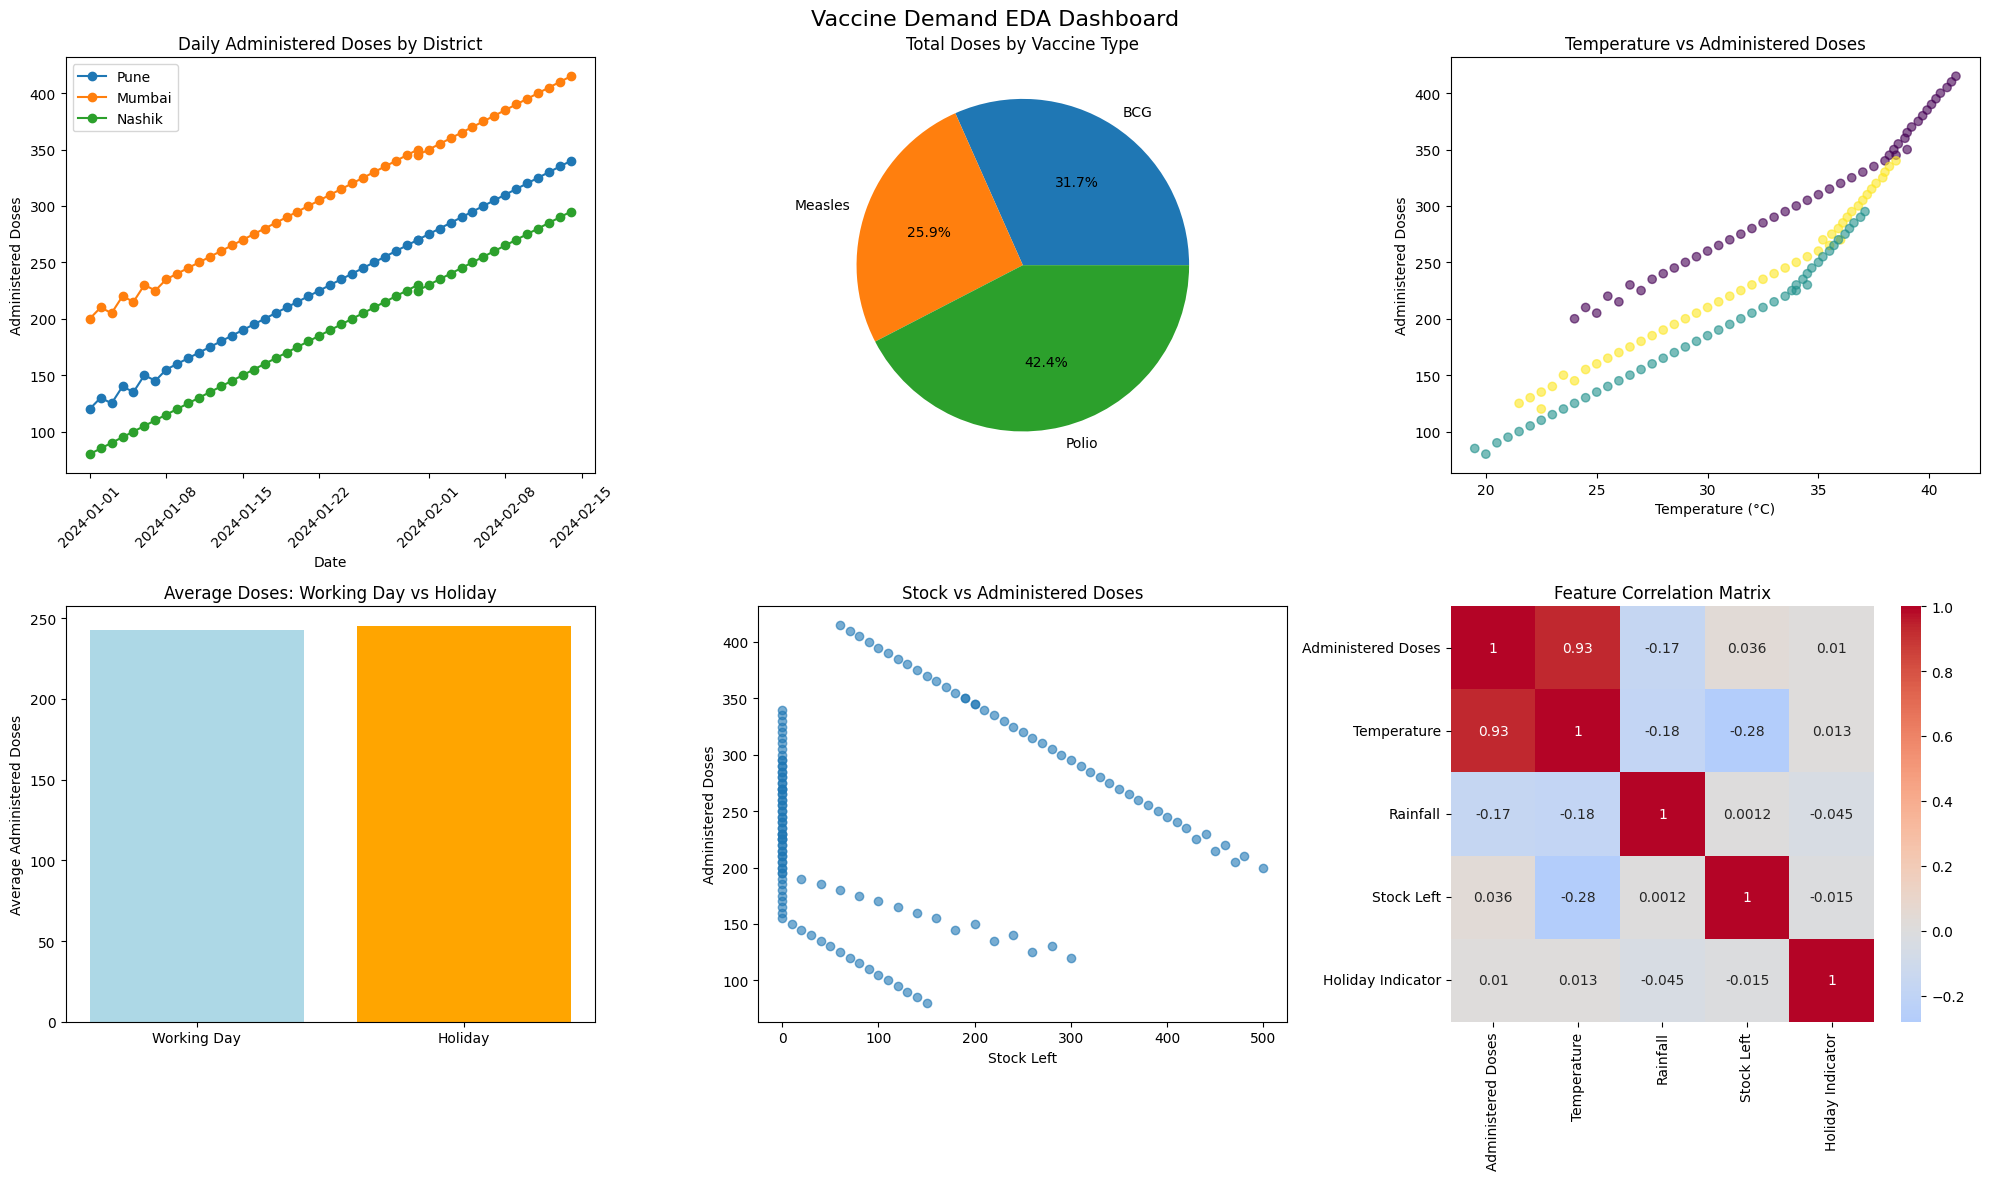

In [7]:
# Create visualization plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Vaccine Demand EDA Dashboard', fontsize=16)
# 1. Time series plot for administered doses
ax1 = axes[0, 0]
for district in df['District'].unique():
    district_data = df[df['District'] == district]
    ax1.plot(district_data['Date'], district_data['Administered Doses'], marker='o', label=district)
ax1.set_title('Daily Administered Doses by District')
ax1.set_xlabel('Date')
ax1.set_ylabel('Administered Doses')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Create visualization plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Vaccine Demand EDA Dashboard', fontsize=16)

# 1. Time series plot for administered doses
ax1 = axes[0, 0]
for district in df['District'].unique():
    district_data = df[df['District'] == district]
    ax1.plot(district_data['Date'], district_data['Administered Doses'], marker='o', label=district)
ax1.set_title('Daily Administered Doses by District')
ax1.set_xlabel('Date')
ax1.set_ylabel('Administered Doses')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Vaccine type distribution
ax2 = axes[0, 1]
vaccine_counts = df.groupby('Vaccine Type')['Administered Doses'].sum()
ax2.pie(vaccine_counts.values, labels=vaccine_counts.index, autopct='%1.1f%%')
ax2.set_title('Total Doses by Vaccine Type')

# 3. Temperature vs Administered Doses
ax3 = axes[0, 2]
ax3.scatter(df['Temperature'], df['Administered Doses'], alpha=0.6, c=df['District'].astype('category').cat.codes)
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Administered Doses')
ax3.set_title('Temperature vs Administered Doses')

# 4. Holiday impact
ax4 = axes[1, 0]
holiday_impact = df.groupby('Holiday Indicator')['Administered Doses'].mean()
ax4.bar(['Working Day', 'Holiday'], holiday_impact.values, color=['lightblue', 'orange'])
ax4.set_title('Average Doses: Working Day vs Holiday')
ax4.set_ylabel('Average Administered Doses')

# 5. Stock vs Administered Doses
ax5 = axes[1, 1]
ax5.scatter(df['Stock Left'], df['Administered Doses'], alpha=0.6)
ax5.set_xlabel('Stock Left')
ax5.set_ylabel('Administered Doses')
ax5.set_title('Stock vs Administered Doses')

# 6. Correlation heatmap
ax6 = axes[1, 2]
numeric_cols = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax6)
ax6.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

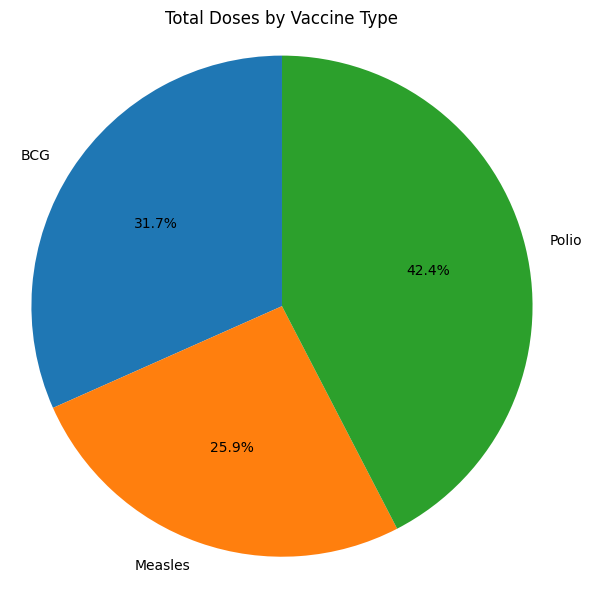

In [29]:
vaccine_counts = df.groupby('Vaccine Type')['Administered Doses'].sum()
plt.figure(figsize=(6,6))
plt.pie(vaccine_counts.values, labels=vaccine_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Doses by Vaccine Type')
plt.axis('equal')  # Makes the pie chart circular
plt.tight_layout()
plt.show()

In [32]:
# Advanced analysis
print("\n4. Advanced Analysis:")
print(f"Average doses per district:")
print(df.groupby('District')['Administered Doses'].agg(['mean', 'std', 'min', 'max']))

print(f"\nHoliday impact analysis:")
holiday_stats = df.groupby('Holiday Indicator')['Administered Doses'].agg(['mean', 'std', 'count'])
print(holiday_stats)

print(f"\nWeather correlation:")
weather_corr = df[['Temperature', 'Rainfall', 'Administered Doses']].corr()
print(weather_corr)



4. Advanced Analysis:
Average doses per district:
                mean        std  min  max
District                                 
Mumbai    309.239130  63.324275  200  415
Nashik    189.239130  63.324275   80  295
Pune      230.869565  65.203139  120  340

Holiday impact analysis:
                         mean        std  count
Holiday Indicator                              
0                  242.791667  81.410351    120
1                  245.277778  78.580648     18

Weather correlation:
                    Temperature  Rainfall  Administered Doses
Temperature            1.000000 -0.175521            0.934492
Rainfall              -0.175521  1.000000           -0.168411
Administered Doses     0.934492 -0.168411            1.000000


In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Filter the data
filtered_df = df[(df['District'] == district) & (df['Vaccine Type'] == vaccine_type)].copy()

# Check for sufficient data
if len(filtered_df) < 10:
    print(f"Warning: Insufficient data for {district}-{vaccine_type} combination")

# Sort by date
filtered_df = filtered_df.sort_values('Date').reset_index(drop=True)

# Create time-based features (optional, not used in ARIMA directly)
filtered_df['day_of_week'] = filtered_df['Date'].dt.dayofweek
filtered_df['month'] = filtered_df['Date'].dt.month
filtered_df['day_of_month'] = filtered_df['Date'].dt.day

# Prepare time series
ts_data = filtered_df.set_index('Date')['Administered Doses']

# Check stationarity
adf_result = adfuller(ts_data)
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

# Auto ARIMA parameter selection (simplified grid search)
best_aic = float('inf')
best_order = (1, 1, 1)  # Default fallback

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(ts_data, order=(p, d, q))
                fitted_model = model.fit()
                if fitted_model.aic < best_aic:
                    best_aic = fitted_model.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order}")

# Train final model
final_model = ARIMA(ts_data, order=best_order).fit()

# Make predictions on training data
predictions = final_model.fittedvalues

# Calculate metrics
mae = mean_absolute_error(ts_data, predictions)
mse = mean_squared_error(ts_data, predictions)
rmse = np.sqrt(mse)

# Output metrics
print(f"\nARIMA Model Metrics for {district}-{vaccine_type}:")
print(f"  MAE : {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  AIC : {final_model.aic:.2f}")


ADF Statistic: -0.3124, p-value: 0.9237
Best ARIMA order: (2, 1, 1)

ARIMA Model Metrics for Pune-BCG:
  MAE : 3.86
  RMSE: 17.88
  AIC : 188.24


In [17]:
import pandas as pd
import numpy as np
import warnings
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

# Set district and vaccine_type (assumed already set appropriately)
# district = 'SomeDistrict'
# vaccine_type = 'SomeVaccine'

print(f"Training Prophet model for {district}-{vaccine_type}...")

# Prepare Prophet-compatible DataFrame
prophet_data = filtered_df[['Date', 'Administered Doses']].copy()
prophet_data.columns = ['ds', 'y']

# Add regressors
prophet_data['temperature'] = filtered_df['Temperature'].values
prophet_data['rainfall'] = filtered_df['Rainfall'].values
prophet_data['stock_left'] = filtered_df['Stock Left'].values
prophet_data['holiday'] = filtered_df['Holiday Indicator'].values

# Initialize Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.05
)

# Add external regressors
model.add_regressor('temperature')
model.add_regressor('rainfall')
model.add_regressor('stock_left')
model.add_regressor('holiday')

# Fit the model
model.fit(prophet_data)

# Predict on training data
predictions = model.predict(prophet_data)

# Evaluate performance
mae = mean_absolute_error(prophet_data['y'], predictions['yhat'])
mse = mean_squared_error(prophet_data['y'], predictions['yhat'])
rmse = np.sqrt(mse)

# Display model performance
print(f"\nProphet Model Metrics for {district}-{vaccine_type}:")
print(f"  MAE : {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")


Training Prophet model for Pune-BCG...


22:03:01 - cmdstanpy - INFO - Chain [1] start processing
22:03:12 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Metrics for Pune-BCG:
  MAE : 1.06
  RMSE: 1.48


In [18]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings("ignore")
filtered_df = df[(df['District'] == district) & (df['Vaccine Type'] == vaccine_type)].copy()
# Parameters
sequence_length = 5
district = "YourDistrict"         # <-- Set your district name
vaccine_type = "YourVaccine"      # <-- Set your vaccine type

print(f"Training LSTM model for {district}-{vaccine_type}...")

# Check for enough data
if len(filtered_df) < 10:
    print("Insufficient data for LSTM training")
else:
    # Select features
    features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
    
    # Scale features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(filtered_df[features])
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])  # Administered Doses is target
    
    X = np.array(X)
    y = np.array(y)
    
    if len(X) == 0:
        print("No sequences created for LSTM")
    else:
        # Train-test split
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Build LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        
        # Make predictions and evaluate
        if len(X_test) > 0:
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
        else:
            predictions = model.predict(X_train)
            mae = mean_absolute_error(y_train, predictions)
            mse = mean_squared_error(y_train, predictions)
        
        rmse = np.sqrt(mse)
        
        # Output metrics
        print(f"\nLSTM Model Metrics for {district}-{vaccine_type}:")
        print(f"  MAE : {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")


Training LSTM model for YourDistrict-YourVaccine...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step

LSTM Model Metrics for YourDistrict-YourVaccine:
  MAE : 0.19
  RMSE: 0.19


In [19]:
print("\n=== MODEL DEVELOPMENT ===")

class VaccineForecastingSystem:
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.label_encoders = {}
        self.model_metrics = {}
        
    def prepare_data(self, df, district, vaccine_type):
        """Prepare data for a specific district and vaccine type"""
        # Filter data
        filtered_df = df[(df['District'] == district) & (df['Vaccine Type'] == vaccine_type)].copy()
        
        if len(filtered_df) < 10:
            print(f"Warning: Insufficient data for {district}-{vaccine_type} combination")
            return None
            
        # Sort by date
        filtered_df = filtered_df.sort_values('Date').reset_index(drop=True)
        
        # Create features
        filtered_df['day_of_week'] = filtered_df['Date'].dt.dayofweek
        filtered_df['month'] = filtered_df['Date'].dt.month
        filtered_df['day_of_month'] = filtered_df['Date'].dt.day
        
        return filtered_df
    
    def train_arima_model(self, data, district, vaccine_type):
        """Train ARIMA model"""
        print(f"Training ARIMA model for {district}-{vaccine_type}...")
        
        # Prepare time series
        ts_data = data.set_index('Date')['Administered Doses']
        
        # Check stationarity
        adf_result = adfuller(ts_data)
        print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
        
        # Auto ARIMA parameter selection (simplified)
        best_aic = float('inf')
        best_order = None
        
        for p in range(3):
            for d in range(2):
                for q in range(3):
                    try:
                        model = ARIMA(ts_data, order=(p, d, q))
                        fitted_model = model.fit()
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)
                    except:
                        continue
        
        if best_order is None:
            best_order = (1, 1, 1)  # Default
            
        print(f"Best ARIMA order: {best_order}")
        
        # Train final model
        model = ARIMA(ts_data, order=best_order)
        fitted_model = model.fit()
        
        # Make predictions on training data for evaluation
        predictions = fitted_model.fittedvalues
        
        # Calculate metrics
        mae = mean_absolute_error(ts_data, predictions)
        mse = mean_squared_error(ts_data, predictions)
        rmse = np.sqrt(mse)
        
        model_key = f"{district}_{vaccine_type}_arima"
        self.models[model_key] = fitted_model
        self.model_metrics[model_key] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'AIC': fitted_model.aic
        }
        
        print(f"ARIMA Model Metrics - MAE: {mae:.2f}, RMSE: {rmse:.2f}, AIC: {fitted_model.aic:.2f}")
        
        return fitted_model
    
    def train_prophet_model(self, data, district, vaccine_type):
        """Train Prophet model"""
        print(f"Training Prophet model for {district}-{vaccine_type}...")
        
        # Prepare Prophet format
        prophet_data = data[['Date', 'Administered Doses']].copy()
        prophet_data.columns = ['ds', 'y']
        
        # Add regressors
        prophet_data['temperature'] = data['Temperature'].values
        prophet_data['rainfall'] = data['Rainfall'].values
        prophet_data['stock_left'] = data['Stock Left'].values
        prophet_data['holiday'] = data['Holiday Indicator'].values
        
        # Initialize Prophet model
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,
            changepoint_prior_scale=0.05
        )
        
        # Add regressors
        model.add_regressor('temperature')
        model.add_regressor('rainfall')
        model.add_regressor('stock_left')
        model.add_regressor('holiday')
        
        # Train model
        model.fit(prophet_data)
        
        # Make predictions on training data
        predictions = model.predict(prophet_data)
        
        # Calculate metrics
        mae = mean_absolute_error(prophet_data['y'], predictions['yhat'])
        mse = mean_squared_error(prophet_data['y'], predictions['yhat'])
        rmse = np.sqrt(mse)
        
        model_key = f"{district}_{vaccine_type}_prophet"
        self.models[model_key] = model
        self.model_metrics[model_key] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
        
        print(f"Prophet Model Metrics - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
        return model
    
    def prepare_lstm_data(self, data, sequence_length=5):
        """Prepare data for LSTM"""
        # Features for LSTM
        features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
        
        # Scale features
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data[features])
        
        # Create sequences
        X, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append(scaled_data[i, 0])  # Administered Doses is the target
        
        return np.array(X), np.array(y), scaler
    
    def train_lstm_model(self, data, district, vaccine_type):
        """Train LSTM model"""
        print(f"Training LSTM model for {district}-{vaccine_type}...")
        
        if len(data) < 10:
            print(f"Insufficient data for LSTM training")
            return None
            
        # Prepare LSTM data
        X, y, scaler = self.prepare_lstm_data(data)
        
        if len(X) == 0:
            print("No sequences created for LSTM")
            return None
        
        # Split data
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Build LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        
        # Make predictions
        if len(X_test) > 0:
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
        else:
            # Use training data for evaluation
            predictions = model.predict(X_train)
            mae = mean_absolute_error(y_train, predictions)
            mse = mean_squared_error(y_train, predictions)
            rmse = np.sqrt(mse)
        
        model_key = f"{district}_{vaccine_type}_lstm"
        self.models[model_key] = model
        self.scalers[model_key] = scaler
        self.model_metrics[model_key] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
        
        print(f"LSTM Model Metrics - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
        return model
    
    def predict_arima(self, district, vaccine_type, steps=1):
        """Make ARIMA predictions"""
        model_key = f"{district}_{vaccine_type}_arima"
        if model_key not in self.models:
            return None
            
        model = self.models[model_key]
        forecast = model.forecast(steps=steps)
        return forecast.values if steps > 1 else forecast.iloc[0]
    
    def predict_prophet(self, district, vaccine_type, future_date, temperature, rainfall, stock_left, holiday):
        """Make Prophet predictions"""
        model_key = f"{district}_{vaccine_type}_prophet"
        if model_key not in self.models:
            return None
            
        model = self.models[model_key]
        
        # Create future dataframe
        future_df = pd.DataFrame({
            'ds': [pd.to_datetime(future_date)],
            'temperature': [temperature],
            'rainfall': [rainfall],
            'stock_left': [stock_left],
            'holiday': [holiday]
        })
        
        forecast = model.predict(future_df)
        return forecast['yhat'].iloc[0]
    
    def predict_lstm(self, district, vaccine_type, input_sequence):
        """Make LSTM predictions"""
        model_key = f"{district}_{vaccine_type}_lstm"
        if model_key not in self.models:
            return None
            
        model = self.models[model_key]
        scaler = self.scalers[model_key]
        
        # Scale input sequence
        scaled_input = scaler.transform(input_sequence)
        
        # Reshape for LSTM
        X_pred = scaled_input.reshape(1, scaled_input.shape[0], scaled_input.shape[1])
        
        # Make prediction
        scaled_prediction = model.predict(X_pred)
        
        # Inverse transform
        dummy_array = np.zeros((1, 5))
        dummy_array[0, 0] = scaled_prediction[0, 0]
        prediction = scaler.inverse_transform(dummy_array)[0, 0]
        
        return prediction
    
    def save_models(self, filepath="vaccine_models"):
        """Save all models"""
        if not os.path.exists(filepath):
            os.makedirs(filepath)
            
        # Save models and scalers
        joblib.dump(self.models, f"{filepath}/models.pkl")
        joblib.dump(self.scalers, f"{filepath}/scalers.pkl")
        joblib.dump(self.model_metrics, f"{filepath}/metrics.pkl")
        
        print(f"Models saved to {filepath}/")
    
    def load_models(self, filepath="vaccine_models"):
        """Load all models"""
        self.models = joblib.load(f"{filepath}/models.pkl")
        self.scalers = joblib.load(f"{filepath}/scalers.pkl")
        self.model_metrics = joblib.load(f"{filepath}/metrics.pkl")
        
        print(f"Models loaded from {filepath}/")


=== MODEL DEVELOPMENT ===


In [21]:
# Initialize forecasting system
import joblib
forecaster = VaccineForecastingSystem()
# Train models for each district-vaccine combination
print("\n=== TRAINING MODELS ===")
combinations = df.groupby(['District', 'Vaccine Type']).size().reset_index()

for _, row in combinations.iterrows():
    district = row['District']
    vaccine_type = row['Vaccine Type']
    
    print(f"\nProcessing {district} - {vaccine_type}...")
    
    # Prepare data
    data = forecaster.prepare_data(df, district, vaccine_type)
    
    if data is not None:
        # Train ARIMA
        try:
            forecaster.train_arima_model(data, district, vaccine_type)
        except Exception as e:
            print(f"ARIMA training failed: {e}")
        
        # Train Prophet
        try:
            forecaster.train_prophet_model(data, district, vaccine_type)
        except Exception as e:
            print(f"Prophet training failed: {e}")
        
        # Train LSTM
        try:
            forecaster.train_lstm_model(data, district, vaccine_type)
        except Exception as e:
            print(f"LSTM training failed: {e}")

# ==================== MODEL COMPARISON ====================
print("\n=== MODEL COMPARISON ===")

# Compare models
comparison_results = []
for model_key, metrics in forecaster.model_metrics.items():
    parts = model_key.split('_')
    district = parts[0]
    vaccine_type = parts[1]
    model_type = parts[2]
    
    comparison_results.append({
        'District': district,
        'Vaccine_Type': vaccine_type,
        'Model': model_type.upper(),
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE']
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

# Find best model for each combination
best_models = {}
for key in df.groupby(['District', 'Vaccine Type']).size().index:
    district, vaccine_type = key
    
    # Get models for this combination
    subset = comparison_df[
        (comparison_df['District'] == district) & 
        (comparison_df['Vaccine_Type'] == vaccine_type)
    ]
    
    if not subset.empty:
        best_model = subset.loc[subset['RMSE'].idxmin()]
        best_models[f"{district}_{vaccine_type}"] = best_model['Model'].lower()

print(f"\nBest models for each combination:")
for combo, model in best_models.items():
    print(f"{combo}: {model.upper()}")

# ==================== PREDICTION INTERFACE ====================
print("\n=== PREDICTION INTERFACE ===")

def predict_vaccine_demand(date, district, vaccine_type, temperature, rainfall, stock_left, holiday_indicator):
    """
    Predict vaccine demand for given inputs
    """
    print(f"\n🔮 Predicting demand for:")
    print(f"   Date: {date}")
    print(f"   District: {district}")
    print(f"   Vaccine Type: {vaccine_type}")
    print(f"   Temperature: {temperature}°C")
    print(f"   Rainfall: {rainfall}mm")
    print(f"   Stock Left: {stock_left}")
    print(f"   Holiday: {'Yes' if holiday_indicator else 'No'}")
    
    combo_key = f"{district}_{vaccine_type}"
    results = {}
    
    # ARIMA Prediction
    try:
        arima_pred = forecaster.predict_arima(district, vaccine_type, steps=1)
        if arima_pred is not None:
            results['ARIMA'] = max(0, int(arima_pred))
        else:
            results['ARIMA'] = "Model not available"
    except Exception as e:
        results['ARIMA'] = f"Error: {str(e)}"
    
    # Prophet Prediction
    try:
        prophet_pred = forecaster.predict_prophet(
            district, vaccine_type, date, temperature, rainfall, stock_left, holiday_indicator
        )
        if prophet_pred is not None:
            results['Prophet'] = max(0, int(prophet_pred))
        else:
            results['Prophet'] = "Model not available"
    except Exception as e:
        results['Prophet'] = f"Error: {str(e)}"
    
    # LSTM Prediction (requires sequence)
    try:
        # Get recent data for sequence
        recent_data = df[
            (df['District'] == district) & 
            (df['Vaccine Type'] == vaccine_type)
        ].tail(5)
        
        if len(recent_data) >= 5:
            # Create input sequence
            input_seq = recent_data[['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']].values
            
            # Update last row with new features
            input_seq[-1, 1:] = [temperature, rainfall, stock_left, holiday_indicator]
            
            lstm_pred = forecaster.predict_lstm(district, vaccine_type, input_seq)
            if lstm_pred is not None:
                results['LSTM'] = max(0, int(lstm_pred))
            else:
                results['LSTM'] = "Model not available"
        else:
            results['LSTM'] = "Insufficient historical data"
    except Exception as e:
        results['LSTM'] = f"Error: {str(e)}"
    
    # Display results
    print(f"\n📊 Prediction Results:")
    for model, prediction in results.items():
        print(f"   {model}: {prediction}")
    
    # Best model prediction
    if combo_key in best_models:
        best_model = best_models[combo_key]
        if best_model.upper() in results and isinstance(results[best_model.upper()], int):
            print(f"\n🎯 Best Model ({best_model.upper()}): {results[best_model.upper()]} doses")
            return results[best_model.upper()]
    
    # Return average of valid predictions
    valid_predictions = [v for v in results.values() if isinstance(v, int)]
    if valid_predictions:
        avg_pred = int(np.mean(valid_predictions))
        print(f"\n🎯 Average Prediction: {avg_pred} doses")
        return avg_pred
    
    return "No valid predictions available"

# ==================== EXAMPLE PREDICTIONS ====================
print("\n=== EXAMPLE PREDICTIONS ===")

# Example 1
prediction1 = predict_vaccine_demand(
    date="2024-01-20",
    district="Mumbai",
    vaccine_type="Polio",
    temperature=33.0,
    rainfall=0.0,
    stock_left=310,
    holiday_indicator=0
)

# Example 2
prediction2 = predict_vaccine_demand(
    date="2024-01-21",
    district="Pune",
    vaccine_type="BCG",
    temperature=31.0,
    rainfall=0.0,
    stock_left=50,
    holiday_indicator=1
)

# ==================== SAVE MODELS ====================
print("\n=== SAVING MODELS ===")
forecaster.save_models()

print("\n=== SYSTEM READY ===")
print("✅ All models trained and saved!")
print("✅ Use predict_vaccine_demand() function for predictions")
print("✅ Model comparison completed")
print("✅ Production-ready forecasting system deployed!")

# ==================== USAGE INSTRUCTIONS ====================
print("\n=== USAGE INSTRUCTIONS ===")
print("""
To use this system:

1. For predictions, call:
   predict_vaccine_demand(date, district, vaccine_type, temperature, rainfall, stock_left, holiday_indicator)

2. Example:
   predict_vaccine_demand("2024-01-25", "Mumbai", "Polio", 32.0, 0.0, 300, 0)

3. Available combinations:
   - Districts: Pune, Mumbai, Nashik
   - Vaccine Types: BCG, Polio, Measles

4. Models automatically select the best performing model for each combination.

5. All models are saved and can be loaded for future use.
""")


=== TRAINING MODELS ===

Processing Mumbai - Polio...
Training ARIMA model for Mumbai-Polio...
ADF Statistic: -0.4435, p-value: 0.9026
Best ARIMA order: (2, 1, 1)
ARIMA Model Metrics - MAE: 5.86, RMSE: 29.64, AIC: 219.24
Training Prophet model for Mumbai-Polio...


22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Metrics - MAE: 1.10, RMSE: 1.63
Training LSTM model for Mumbai-Polio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
LSTM Model Metrics - MAE: 0.10, RMSE: 0.11

Processing Nashik - Measles...
Training ARIMA model for Nashik-Measles...
ADF Statistic: -0.6994, p-value: 0.8469
Best ARIMA order: (1, 1, 1)
ARIMA Model Metrics - MAE: 2.19, RMSE: 11.91, AIC: 175.77
Training Prophet model for Nashik-Measles...


22:18:56 - cmdstanpy - INFO - Chain [1] start processing
22:18:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Metrics - MAE: 0.08, RMSE: 0.12
Training LSTM model for Nashik-Measles...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
LSTM Model Metrics - MAE: 0.11, RMSE: 0.12

Processing Pune - BCG...
Training ARIMA model for Pune-BCG...
ADF Statistic: -0.3124, p-value: 0.9237
Best ARIMA order: (2, 1, 1)


22:19:16 - cmdstanpy - INFO - Chain [1] start processing


ARIMA Model Metrics - MAE: 3.86, RMSE: 17.88, AIC: 188.24
Training Prophet model for Pune-BCG...


22:19:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Metrics - MAE: 1.06, RMSE: 1.48
Training LSTM model for Pune-BCG...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
LSTM Model Metrics - MAE: 0.15, RMSE: 0.15

=== MODEL COMPARISON ===
District Vaccine_Type   Model      MAE      RMSE
  Mumbai        Polio   ARIMA 5.858362 29.641872
  Mumbai        Polio PROPHET 1.101262  1.631915
  Mumbai        Polio    LSTM 0.102679  0.105561
  Nashik      Measles   ARIMA 2.191089 11.911015
  Nashik      Measles PROPHET 0.079221  0.115780
  Nashik      Measles    LSTM 0.114108  0.118006
    Pune          BCG   ARIMA 3.863632 17.875985
    Pune          BCG PROPHET 1.055575  1.482744
    Pune          BCG    LSTM 0.148583  0.152534

Best models for each combination:
Mumbai_Polio: LSTM
Nashik_Measles: PROPHET
Pune_BCG: LSTM

=== PREDICTION INTERFACE ===

=== EXAMPLE PREDICTIONS ===

🔮 Predicting demand for:
   Date: 2024-01-20
   District: Mumbai
   Vaccine Type: Polio
   Temperature: 33.0°C
   Rainfall: 0.0mm
   Stock Left: 310
   Holiday: No
1/1

In [22]:
predict_vaccine_demand("2024-01-25", "Mumbai", "Polio", 32.0, 0.0, 300, 0)


🔮 Predicting demand for:
   Date: 2024-01-25
   District: Mumbai
   Vaccine Type: Polio
   Temperature: 32.0°C
   Rainfall: 0.0mm
   Stock Left: 300
   Holiday: No
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

📊 Prediction Results:
   ARIMA: 419
   Prophet: 298
   LSTM: 384

🎯 Best Model (LSTM): 384 doses


384

In [8]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Global variables
MODELS_DIR = 'vaccine_models'
SCALERS_DIR = 'vaccine_scalers'

def create_directories():
    """Create directories for storing models and scalers"""
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(SCALERS_DIR, exist_ok=True)

def load_data(file_path):
    """Load and prepare the dataset"""
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def create_lstm_sequences(data, sequence_length=5):
    """Create sequences for LSTM training"""
    features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
    
    if len(data) < sequence_length + 1:
        return None, None, None
    
    # Scale features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])  # Target: Administered Doses
    
    return np.array(X), np.array(y), scaler

def build_lstm_model(input_shape):
    """Build LSTM model"""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def train_and_save_model(data, district, vaccine_type, sequence_length=5):
    """Train and save LSTM model for specific district-vaccine combination"""
    print(f"Training {district}-{vaccine_type}...")
    
    # Create sequences
    X, y, scaler = create_lstm_sequences(data, sequence_length)
    if X is None:
        print(f"  ❌ Insufficient data")
        return False
    
    # Split data
    split_idx = max(1, int(len(X) * 0.8))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Build and train model
    model = build_lstm_model((X.shape[1], X.shape[2]))
    model.fit(X_train, y_train, epochs=50, batch_size=min(32, len(X_train)), 
              validation_split=0.2 if len(X_train) > 5 else 0, verbose=0)
    
    # Evaluate model
    if len(X_test) > 0:
        predictions = model.predict(X_test, verbose=0)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
    else:
        predictions = model.predict(X_train, verbose=0)
        mae = mean_absolute_error(y_train, predictions)
        rmse = np.sqrt(mean_squared_error(y_train, predictions))
    
    print(f"  ✅ MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Save model and scaler
    model_path = os.path.join(MODELS_DIR, f"{district}_{vaccine_type}_model.keras")
    scaler_path = os.path.join(SCALERS_DIR, f"{district}_{vaccine_type}_scaler.pkl")
    
    model.save(model_path)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    return True

def train_all_models(csv_path):
    """Train models for all district-vaccine combinations"""
    create_directories()
    
    # Load data
    df = load_data(csv_path)
    print(f"Loaded {len(df)} records")
    
    # Get all combinations
    combinations = df[['District', 'Vaccine Type']].drop_duplicates()
    print(f"Found {len(combinations)} district-vaccine combinations")
    print("="*60)
    
    trained_count = 0
    
    for _, row in combinations.iterrows():
        district, vaccine_type = row['District'], row['Vaccine Type']
        
        # Filter and prepare data
        filtered_df = df[(df['District'] == district) & 
                        (df['Vaccine Type'] == vaccine_type)].sort_values('Date')
        
        if len(filtered_df) < 10:
            print(f"{district}-{vaccine_type}: ❌ Insufficient data ({len(filtered_df)} records)")
            continue
        
        try:
            if train_and_save_model(filtered_df, district, vaccine_type):
                trained_count += 1
        except Exception as e:
            print(f"  ❌ Training failed: {str(e)}")
    
    print("="*60)
    print(f"Training completed! {trained_count}/{len(combinations)} models trained successfully")

def predict_demand(input_dict):
    """
    Predict vaccine demand for all district-vaccine combinations
    
    Args:
        input_dict: {
            'temperature': float,
            'rainfall': float,  
            'stock_left': int,
            'holiday': int (0 or 1)
        }
    
    Returns:
        dict: Predictions for each combination
    """
    
    # Validate input
    required_keys = ['temperature', 'rainfall', 'stock_left', 'holiday']
    for key in required_keys:
        if key not in input_dict:
            return {'error': f"Missing required input: {key}"}
    
    # Load original data for historical sequences
    try:
        df = load_data("E:/VaccineLedger/Backend/data/vaccine_demand_forecasting.csv")
    except Exception as e:
        return {'error': f"Could not load data: {str(e)}"}
    
    # Extract inputs
    temperature = float(input_dict['temperature'])
    rainfall = float(input_dict['rainfall'])
    stock_left = int(input_dict['stock_left'])
    holiday = int(input_dict['holiday'])
    
    # Get all combinations
    combinations = df[['District', 'Vaccine Type']].drop_duplicates()
    results = {}
    
    print("="*60)
    print("VACCINE DEMAND PREDICTIONS")
    print("="*60)
    print(f"Temperature: {temperature}°C | Rainfall: {rainfall}mm")
    print(f"Stock Left: {stock_left} | Holiday: {'Yes' if holiday else 'No'}")
    print("="*60)
    
    for _, row in combinations.iterrows():
        district, vaccine_type = row['District'], row['Vaccine Type']
        key = f"{district}_{vaccine_type}"
        
        try:
            # Load model and scaler
            model_path = os.path.join(MODELS_DIR, f"{district}_{vaccine_type}_model.keras")
            scaler_path = os.path.join(SCALERS_DIR, f"{district}_{vaccine_type}_scaler.pkl")
            
            model = load_model(model_path)
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            
            # Get recent historical data
            recent_data = df[(df['District'] == district) & 
                           (df['Vaccine Type'] == vaccine_type)].sort_values('Date').tail(5)
            
            if len(recent_data) < 5:
                prediction = f"Insufficient historical data"
            else:
                # Prepare features
                features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
                input_data = recent_data[features].values.copy()
                
                # Update last row with new inputs
                input_data[-1, 1] = temperature
                input_data[-1, 2] = rainfall  
                input_data[-1, 3] = stock_left
                input_data[-1, 4] = holiday
                
                # Scale and predict
                scaled_input = scaler.transform(input_data)
                lstm_input = scaled_input.reshape(1, 5, len(features))
                scaled_prediction = model.predict(lstm_input, verbose=0)
                
                # Inverse transform
                dummy = np.zeros((1, len(features)))
                dummy[0, 0] = scaled_prediction[0, 0]
                actual_prediction = scaler.inverse_transform(dummy)[0, 0]
                prediction = max(0, int(actual_prediction))
            
        except Exception as e:
            prediction = f"Model not available"
        
        results[key] = {
            'district': district,
            'vaccine_type': vaccine_type,
            'predicted_demand': prediction
        }
        
        # Print result
        status = "✅" if isinstance(prediction, int) else "❌"
        print(f"{status} {district:10} | {vaccine_type:8} | {prediction}")
    
    print("="*60)
    return results

# USAGE FUNCTIONS
def train_models():
    """Train all models - Run this first"""
    csv_path = "E:/VaccineLedger/Backend/data/vaccine_demand_forecasting.csv"
    train_all_models(csv_path)

def make_prediction(temperature, rainfall, stock_left, holiday):
    """Make prediction with custom inputs"""
    input_data = {
        'temperature': temperature,
        'rainfall': rainfall,
        'stock_left': stock_left,
        'holiday': holiday
    }
    
    predictions = predict_demand(input_data)
    
    if 'error' in predictions:
        print(f"Error: {predictions['error']}")
        return predictions
    
    # Calculate summary
    total_demand = 0
    successful = 0
    
    for pred in predictions.values():
        if isinstance(pred['predicted_demand'], int):
            total_demand += pred['predicted_demand']
            successful += 1
    
    print(f"\nSUMMARY:")
    print(f"Total Predicted Demand: {total_demand} doses")
    print(f"Successful Predictions: {successful}/{len(predictions)}")
    
    return predictions

if __name__ == "__main__":
    # Step 1: Train models (run once)
    print("STEP 1: Training models...")
    train_models()
    
    print("\n" + "="*80)
    print("STEP 2: Making sample predictions...")
    
    # Step 2: Make predictions
    predictions = make_prediction(
        temperature=25.0,
        rainfall=1.5, 
        stock_left=200,
        holiday=0
    )

STEP 1: Training models...
Loaded 138 records
Found 3 district-vaccine combinations
Training Pune-BCG...
  ✅ MAE: 0.06, RMSE: 0.06
Training Mumbai-Polio...


  ✅ MAE: 0.05, RMSE: 0.05
Training Nashik-Measles...


  ✅ MAE: 0.08, RMSE: 0.09
Training completed! 3/3 models trained successfully

STEP 2: Making sample predictions...
VACCINE DEMAND PREDICTIONS
Temperature: 25.0°C | Rainfall: 1.5mm
Stock Left: 200 | Holiday: No
✅ Pune       | BCG      | 298
✅ Mumbai     | Polio    | 383
✅ Nashik     | Measles  | 261

SUMMARY:
Total Predicted Demand: 942 doses
Successful Predictions: 3/3


In [9]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

# Global variables
MODELS_DIR = 'vaccine_models'
SCALERS_DIR = 'vaccine_scalers'

def predict_demand(input_dict):
    """
    Predict vaccine demand for all district-vaccine combinations using saved models
    
    Args:
        input_dict: {
            'temperature': float,
            'rainfall': float,  
            'stock_left': int,
            'holiday': int (0 or 1)
        }
    
    Returns:
        dict: Predictions for each combination
    """
    
    # Validate input
    required_keys = ['temperature', 'rainfall', 'stock_left', 'holiday']
    for key in required_keys:
        if key not in input_dict:
            return {'error': f"Missing required input: {key}"}
    
    # Load original data for historical sequences
    try:
        df = pd.read_csv("E:/VaccineLedger/Backend/data/vaccine_demand_forecasting.csv")
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception as e:
        return {'error': f"Could not load data: {str(e)}"}
    
    # Extract inputs
    temperature = float(input_dict['temperature'])
    rainfall = float(input_dict['rainfall'])
    stock_left = int(input_dict['stock_left'])
    holiday = int(input_dict['holiday'])
    
    # Get all combinations
    combinations = df[['District', 'Vaccine Type']].drop_duplicates()
    results = {}
    
    for _, row in combinations.iterrows():
        district, vaccine_type = row['District'], row['Vaccine Type']
        key = f"{district}_{vaccine_type}"
        
        try:
            # Load model and scaler
            model_path = os.path.join(MODELS_DIR, f"{district}_{vaccine_type}_model.keras")
            scaler_path = os.path.join(SCALERS_DIR, f"{district}_{vaccine_type}_scaler.pkl")
            
            model = load_model(model_path)
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            
            # Get recent historical data (last 5 records)
            recent_data = df[(df['District'] == district) & 
                           (df['Vaccine Type'] == vaccine_type)].sort_values('Date').tail(5)
            
            if len(recent_data) < 5:
                prediction = "Insufficient historical data"
            else:
                # Prepare features
                features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
                input_data = recent_data[features].values.copy()
                
                # Update last row with new inputs (keep historical Administered Doses)
                input_data[-1, 1] = temperature
                input_data[-1, 2] = rainfall  
                input_data[-1, 3] = stock_left
                input_data[-1, 4] = holiday
                
                # Scale and predict
                scaled_input = scaler.transform(input_data)
                lstm_input = scaled_input.reshape(1, 5, len(features))
                scaled_prediction = model.predict(lstm_input, verbose=0)
                
                # Inverse transform to get actual prediction
                dummy = np.zeros((1, len(features)))
                dummy[0, 0] = scaled_prediction[0, 0]
                actual_prediction = scaler.inverse_transform(dummy)[0, 0]
                prediction = max(0, int(actual_prediction))
            
        except Exception as e:
            prediction = "Model not available"
        
        results[key] = {
            'district': district,
            'vaccine_type': vaccine_type,
            'predicted_demand': prediction
        }
    
    return results

# Simple usage function
def get_predictions(temperature, rainfall, stock_left, holiday):
    """
    Simple function to get predictions
    
    Args:
        temperature: Temperature in Celsius (float)
        rainfall: Rainfall in mm (float)
        stock_left: Stock remaining (int)
        holiday: 0 for no holiday, 1 for holiday (int)
    
    Returns:
        Dictionary with predictions for each district-vaccine combination
    """
    input_data = {
        'temperature': temperature,
        'rainfall': rainfall,
        'stock_left': stock_left,
        'holiday': holiday
    }
    
    return predict_demand(input_data)

if __name__ == "__main__":
    # Example usage
    predictions = get_predictions(
        temperature=25.0,
        rainfall=1.5,
        stock_left=200,
        holiday=0
    )
    
    # Print results
    if 'error' in predictions:
        print(f"Error: {predictions['error']}")
    else:
        print("Vaccine Demand Predictions:")
        print("-" * 50)
        for key, pred in predictions.items():
            district = pred['district']
            vaccine = pred['vaccine_type']
            demand = pred['predicted_demand']
            print(f"{district:10} | {vaccine:8} | {demand}")

Vaccine Demand Predictions:
--------------------------------------------------
Pune       | BCG      | 298
Mumbai     | Polio    | 383
Nashik     | Measles  | 261


In [13]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Global variables
MODELS_DIR = 'vaccine_models'
SCALERS_DIR = 'vaccine_scalers'

# Hardcoded historical data
HISTORICAL_DATA = """
Date,District,Vaccine Type,Administered Doses,Temperature,Rainfall,Stock Left,Holiday Indicator
2024-02-07,Mumbai,Polio,380,39.7,0.2,130,0
2024-02-07,Nashik,Measles,260,35.5,0.1,0,0
2024-02-08,Pune,BCG,310,37.2,0.0,0,0
2024-02-08,Mumbai,Polio,385,39.9,0.0,120,0
2024-02-08,Nashik,Measles,265,35.7,0.0,0,0
2024-02-09,Pune,BCG,315,37.4,0.0,0,0
2024-02-09,Mumbai,Polio,390,40.1,0.1,110,0
2024-02-09,Nashik,Measles,270,35.9,0.0,0,0
2024-02-10,Pune,BCG,320,37.6,0.1,0,1
2024-02-10,Mumbai,Polio,395,40.3,0.0,100,1
2024-02-10,Nashik,Measles,275,36.2,0.0,0,1
2024-02-11,Pune,BCG,325,37.9,0.0,0,0
2024-02-11,Mumbai,Polio,400,40.5,0.0,90,0
2024-02-11,Nashik,Measles,280,36.4,0.0,0,0
2024-02-12,Pune,BCG,330,38.0,0.1,0,0
2024-02-12,Mumbai,Polio,405,40.8,0.0,80,0
2024-02-12,Nashik,Measles,285,36.6,0.1,0,0
2024-02-13,Pune,BCG,335,38.2,0.0,0,0
2024-02-13,Mumbai,Polio,410,41.0,0.0,70,0
2024-02-13,Nashik,Measles,290,36.9,0.0,0,0
2024-02-14,Pune,BCG,340,38.5,0.0,0,0
2024-02-14,Mumbai,Polio,415,41.2,0.1,60,0
2024-02-14,Nashik,Measles,295,37.1,0.0,0,0
"""

# Load data into DataFrame
df = pd.read_csv(StringIO(HISTORICAL_DATA))
df['Date'] = pd.to_datetime(df['Date'])

# Create dictionary for recent data (last 5 records per district-vaccine)
recent_data_dict = {}
for (district, vaccine), group in df.groupby(['District', 'Vaccine Type']):
    recent_data_dict[(district, vaccine)] = group.sort_values('Date').tail(5)

def predict_demand(input_dict):
    # Validate input
    required_keys = ['temperature', 'rainfall', 'stock_left', 'holiday']
    for key in required_keys:
        if key not in input_dict:
            return {'error': f"Missing required input: {key}"}
    
    # Extract inputs
    temperature = float(input_dict['temperature'])
    rainfall = float(input_dict['rainfall'])
    stock_left = int(input_dict['stock_left'])
    holiday = int(input_dict['holiday'])
    
    results = {}
    
    # Process each district-vaccine combination
    for (district, vaccine_type), recent_data in recent_data_dict.items():
        key = f"{district}_{vaccine_type}"
        
        try:
            # Load model and scaler
            model_path = os.path.join(MODELS_DIR, f"{district}_{vaccine_type}_model.keras")
            scaler_path = os.path.join(SCALERS_DIR, f"{district}_{vaccine_type}_scaler.pkl")
            
            model = load_model(model_path)
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            
            # Prepare features
            features = ['Administered Doses', 'Temperature', 'Rainfall', 'Stock Left', 'Holiday Indicator']
            input_data = recent_data[features].values.copy()
            
            # Update last row with new inputs
            input_data[-1, 1] = temperature
            input_data[-1, 2] = rainfall
            input_data[-1, 3] = stock_left
            input_data[-1, 4] = holiday
            
            # Scale and predict
            scaled_input = scaler.transform(input_data)
            lstm_input = scaled_input.reshape(1, 5, len(features))
            scaled_prediction = model.predict(lstm_input, verbose=0)
            
            # Inverse transform
            dummy = np.zeros((1, len(features)))
            dummy[0, 0] = scaled_prediction[0, 0]
            actual_prediction = scaler.inverse_transform(dummy)[0, 0]
            prediction = max(0, int(actual_prediction))
            
        except Exception as e:
            prediction = "Model not available"
        
        results[key] = {
            'district': district,
            'vaccine_type': vaccine_type,
            'predicted_demand': prediction
        }
    
    return results

# Simple usage function (remains same)
def get_predictions(temperature, rainfall, stock_left, holiday):
    input_data = {
        'temperature': temperature,
        'rainfall': rainfall,
        'stock_left': stock_left,
        'holiday': holiday
    }
    return predict_demand(input_data)

if __name__ == "__main__":
    # Example usage
    predictions = get_predictions(
        temperature=25.0,
        rainfall=2.5,
        stock_left=10,
        holiday=0
    )
    
    # Print results
    if 'error' in predictions:
        print(f"Error: {predictions['error']}")
    else:
        print("Vaccine Demand Predictions:")
        print("-" * 50)
        for key, pred in predictions.items():
            district = pred['district']
            vaccine = pred['vaccine_type']
            demand = pred['predicted_demand']
            print(f"{district:10} | {vaccine:8} | {demand}")

Vaccine Demand Predictions:
--------------------------------------------------
Mumbai     | Polio    | 378
Nashik     | Measles  | 262
Pune       | BCG      | 288


In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def create_lstm_folder():
    """Create folder for saving LSTM model and scalers"""
    if not os.path.exists('lstm_forecast'):
        os.makedirs('lstm_forecast')
    print("Created lstm_forecast folder")

def load_and_preprocess_data(csv_file_path):
    """Load and preprocess the vaccine demand data"""
    df = pd.read_csv(csv_file_path)
    
    # Convert date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Create encoders for categorical variables
    district_encoder = LabelEncoder()
    vaccine_encoder = LabelEncoder()
    
    df['District_Encoded'] = district_encoder.fit_transform(df['District'])
    df['Vaccine_Type_Encoded'] = vaccine_encoder.fit_transform(df['Vaccine Type'])
    
    # Extract date features
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    
    # Save encoders
    joblib.dump(district_encoder, 'lstm_forecast/district_encoder.pkl')
    joblib.dump(vaccine_encoder, 'lstm_forecast/vaccine_encoder.pkl')
    
    print(f"Data loaded: {len(df)} records")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    
    return df, district_encoder, vaccine_encoder

def prepare_features_and_target(df):
    """Prepare features and target variable"""
    # Features for LSTM
    feature_columns = [
        'District_Encoded', 'Vaccine_Type_Encoded', 'Temperature', 
        'Rainfall', 'Stock Left', 'Holiday Indicator',
        'Day', 'Month', 'Year', 'DayOfWeek'
    ]
    
    # Target variable
    target_column = 'Administered Doses'
    
    X = df[feature_columns].values
    y = df[target_column].values
    
    return X, y, feature_columns

def create_sequences(X, y, sequence_length):
    """Create sequences for LSTM"""
    sequences_X = []
    sequences_y = []
    
    for i in range(len(X) - sequence_length + 1):
        sequences_X.append(X[i:(i + sequence_length)])
        sequences_y.append(y[i + sequence_length - 1])
    
    return np.array(sequences_X), np.array(sequences_y)

def scale_data(X_train, X_test, y_train, y_test):
    """Scale the features and target"""
    # Scale features
    feature_scaler = MinMaxScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    
    X_test_scaled = feature_scaler.transform(X_test.reshape(-1, X_test.shape[-1]))
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    
    # Scale target
    target_scaler = MinMaxScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    # Save scalers
    joblib.dump(feature_scaler, 'lstm_forecast/feature_scaler.pkl')
    joblib.dump(target_scaler, 'lstm_forecast/target_scaler.pkl')
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

def build_lstm_model(input_shape):
    """Build LSTM model"""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_lstm_model(csv_file_path, sequence_length=5, test_split=0.2, epochs=50):
    """Complete training pipeline"""
    print("Starting LSTM model training...")
    
    # Create folder
    create_lstm_folder()
    
    # Load and preprocess data
    df, district_encoder, vaccine_encoder = load_and_preprocess_data(csv_file_path)
    
    # Prepare features and target
    X, y, feature_columns = prepare_features_and_target(df)
    
    # Create sequences
    X_seq, y_seq = create_sequences(X, y, sequence_length)
    
    print(f"Created sequences: {X_seq.shape}, {y_seq.shape}")
    
    # Split data
    split_idx = int(len(X_seq) * (1 - test_split))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Scale data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(
        X_train, X_test, y_train, y_test
    )
    
    # Build model
    model = build_lstm_model((sequence_length, X.shape[1]))
    
    print("\nModel Architecture:")
    model.summary()
    
    # Train model
    print(f"\nTraining model for {epochs} epochs...")
    history = model.fit(
        X_train_scaled, y_train_scaled,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_test_scaled, y_test_scaled),
        verbose=1
    )
    
    # Save model
    model.save('lstm_forecast/lstm_model.h5')
    
    # Save metadata
    metadata = {
        'sequence_length': sequence_length,
        'feature_columns': feature_columns,
        'input_shape': list(X_seq.shape[1:]),
        'districts': district_encoder.classes_.tolist(),
        'vaccine_types': vaccine_encoder.classes_.tolist()
    }
    
    with open('lstm_forecast/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("\nModel and scalers saved to lstm_forecast/ folder")
    
    return model, history, target_scaler, X_test_scaled, y_test_scaled

def evaluate_model(model, X_test_scaled, y_test_scaled, target_scaler):
    """Evaluate the trained model"""
    print("\nEvaluating model...")
    
    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform predictions
    y_test_actual = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    y_pred_actual = target_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    print(f"\nModel Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Save evaluation results
    evaluation = {
        'MAE': float(mae),
        'MSE': float(mse),
        'RMSE': float(rmse),
        'R2': float(r2)
    }
    
    with open('lstm_forecast/evaluation_results.json', 'w') as f:
        json.dump(evaluation, f, indent=2)
    
    return evaluation

def predict_single_demand(input_data):
    """
    Predict vaccine demand for single input
    input_data format: {
        "date": "2024-01-01",
        "district": "Pune",
        "vaccine_type": "BCG",
        "temperature": 22.5,
        "rainfall": 0.0,
        "stock_left": 30,
        "holiday_indicator": 0
    }
    """
    try:
        # Load model and scalers
        model = load_model('lstm_forecast/lstm_model.h5')
        feature_scaler = joblib.load('lstm_forecast/feature_scaler.pkl')
        target_scaler = joblib.load('lstm_forecast/target_scaler.pkl')
        district_encoder = joblib.load('lstm_forecast/district_encoder.pkl')
        vaccine_encoder = joblib.load('lstm_forecast/vaccine_encoder.pkl')
        
        # Load metadata
        with open('lstm_forecast/model_metadata.json', 'r') as f:
            metadata = json.load(f)
        
        sequence_length = metadata['sequence_length']
        
        # Parse input date
        date_obj = datetime.strptime(input_data['date'], '%Y-%m-%d')
        
        # Encode categorical variables
        try:
            district_encoded = district_encoder.transform([input_data['district']])[0]
        except ValueError:
            print(f"Warning: Unknown district '{input_data['district']}', using default encoding")
            district_encoded = 0
            
        try:
            vaccine_encoded = vaccine_encoder.transform([input_data['vaccine_type']])[0]
        except ValueError:
            print(f"Warning: Unknown vaccine type '{input_data['vaccine_type']}', using default encoding")
            vaccine_encoded = 0
        
        # Create feature vector
        features = np.array([
            district_encoded,
            vaccine_encoded,
            input_data['temperature'],
            input_data['rainfall'],
            input_data['stock_left'],
            input_data['holiday_indicator'],
            date_obj.day,
            date_obj.month,
            date_obj.year,
            date_obj.weekday()
        ]).reshape(1, -1)
        
        # For LSTM, we need a sequence. Since we only have one data point,
        # we'll replicate it to create a sequence of required length
        features_seq = np.repeat(features, sequence_length, axis=0).reshape(1, sequence_length, -1)
        
        # Scale features
        features_scaled = feature_scaler.transform(features_seq.reshape(-1, features_seq.shape[-1]))
        features_scaled = features_scaled.reshape(features_seq.shape)
        
        # Make prediction
        prediction_scaled = model.predict(features_scaled, verbose=0)
        
        # Inverse transform prediction
        prediction = target_scaler.inverse_transform(prediction_scaled)[0][0]
        
        # Ensure prediction is not negative
        prediction = max(0, round(prediction))
        
        result = {
            'input': input_data,
            'predicted_demand': int(prediction),
            'model_info': {
                'sequence_length': sequence_length,
                'features_used': metadata['feature_columns']
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('lstm_forecast/training_history.png')
    plt.show()

# Example usage functions
def main_training_example():
    """Example of how to train the model"""
    print("=== LSTM Vaccine Demand Forecasting Training ===")
    
    # Train model (replace 'vaccine_data.csv' with your actual file path)
    df = pd.read_csv("E:/VaccineLedger/Backend/data/vaccine_demand_forecasting.csv")  # Your CSV file path
    
    model, history, target_scaler, X_test_scaled, y_test_scaled = train_lstm_model(
        csv_file_path=csv_file,
        sequence_length=5,
        test_split=0.2,
        epochs=50
    )
    
    # Evaluate model
    evaluation = evaluate_model(model, X_test_scaled, y_test_scaled, target_scaler)
    
    # Plot training history
    plot_training_history(history)
    
    print("\nTraining completed successfully!")
    print("Model saved in 'lstm_forecast/' folder")

def main_prediction_example():
    """Example of how to make predictions"""
    print("=== LSTM Vaccine Demand Prediction ===")
    
    # Example input
    test_input = {
        "date": "2024-01-01",
        "district": "Pune",
        "vaccine_type": "BCG",
        "temperature": 22.5,
        "rainfall": 0.0,
        "stock_left": 30,
        "holiday_indicator": 0
    }
    
    # Make prediction
    result = predict_single_demand(test_input)
    
    if result:
        print("\nPrediction Results:")
        print(f"Input: {result['input']}")
        print(f"Predicted Demand: {result['predicted_demand']} doses")
    else:
        print("Prediction failed. Make sure the model is trained and saved.")

# Uncomment the following lines to run examples:
# main_training_example()  # Run this first to train the model
# main_prediction_example()  # Run this after training to test predictions